# **Modélisation ElasticNet**

**API SKL** : [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

**Guide SKL** : [**ElasticNet** (1.1.5)](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net)

**Résout** : $\displaystyle\min_{w} { \frac{1}{2n} ||X w - y||_2 ^ 2 + \alpha \rho ||w||_1 + \frac{\alpha(1-\rho)}{2} ||w||_2 ^ 2}$

**Complexité** : ?


## Chargement et nettoyage des données

In [1]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)
# display(data)

✔ _data loaded
✔ struct loaded


## Partition *résidentiel* vs. *non résidentiel*

In [2]:
from seattle_commons import get_family_buildings, get_business_buildings
r_data = get_family_buildings(data)                # residential subset
nr_data = get_business_buildings(data)             # non residential subset

## Config 9 : $\ln{e} = f(\ln{a}, n_\star)$

Contribution du score ENERGYSTAR.

$\{n_\star, \log(a) :\log(e)\}$

Légère dégradation avec un `l1_ratio` à 0.95, i.e. proche de 1.

Interprétation : l'Elastic-Net optimal est le LASSO.

$R^2_{9, \text{Elastic-Net}}$
* $\mu = 0.6166554829149434$
* $\sigma = 0.059789050325773994$

$R^2_{9, \text{LASSO}}$
* $\mu = 0.6166563538370583$
* $\sigma = 0.05979515734612156$

$R^2_{9, \text{Ridge}}$
* $\mu = 0.6166516138510613$
* $\sigma = 0.0599534988115941$

$R^2_{9, \text{OLS}}$
* $\mu = 0.616668067176413$
* $\sigma = 0.059980161457964365$

$R^2_{\text{OLS}, 4} \left(\{\log(a):\log(e)\}\right)$
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [3]:
config_name = "{n_★, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

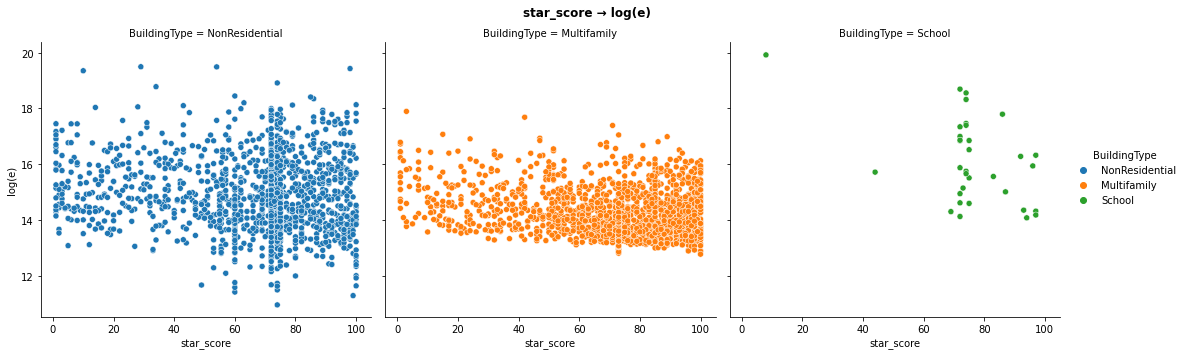

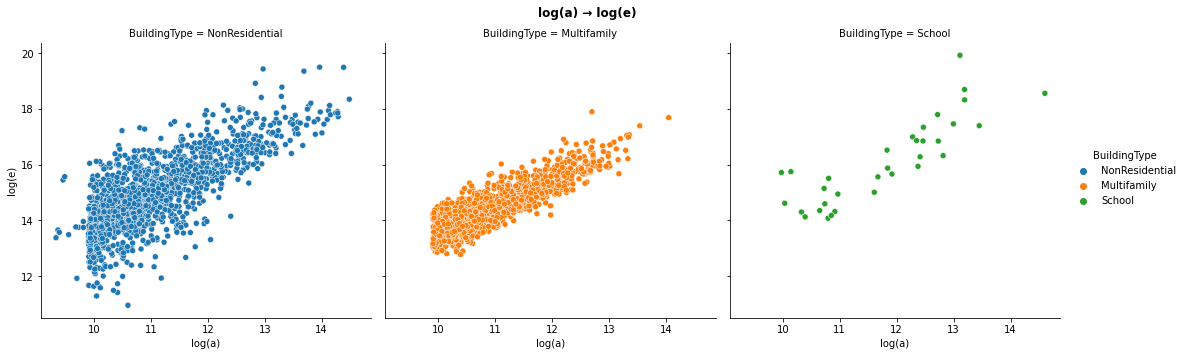

In [4]:
# title="star_score = ENERGYSTARScore → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [4]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [5]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Sélection

In [18]:
#from pepper_skl_commons import lasso_selection
#_ = lasso_selection(X, y)

#### Lasso path using coordinate descent

In [19]:
#from pepper_skl_commons import plot_lasso_coordinate_descent_path
#plot_lasso_coordinate_descent_path(X, y)

#### Entraînement et performances

##### Recherche en grille externe

In [8]:
from pepper_skl_commons import get_lr_baseline_err
from pepper_commons import bold
baseline_err = get_lr_baseline_err(X_train, y_train)
print(bold('LR r2'), ':', baseline_err)

LR r2 : 0.6971301496397384


In [9]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_skl_commons import get_best_params
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Xy = X_train, X_test, y_train, y_test
model = Pipeline([('sc', StandardScaler()), ('en', linear_model.ElasticNet(alpha=1))])
min_alpha_log = -5
max_alpha_log = 5
n_alphas = 100

param_grid = {
    'en__alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'en__l1_ratio': [.5, .7, .8, .85, .9, .95],
    'en__positive': [True, False],
    'en__random_state': [42],
    'en__max_iter': [10_000]
}

gbp_res = (
    best_estimator, best_params, best_score, best_index, scorer, cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [10]:
from pepper_skl_commons import show_best_params
show_best_params(gbp_res, Xy, X, y)


Best
best estimator : Pipeline(steps=[('sc', StandardScaler()),
                ('en',
                 ElasticNet(alpha=0.0042292428743894986, max_iter=10000,
                            random_state=42))])
best params : {'en__alpha': 0.0042292428743894986, 'en__l1_ratio': 0.5, 'en__max_iter': 10000, 'en__positive': False, 'en__random_state': 42}
best score : 0.6971537491749829
best index : 313

Scores
    train score : 0.7062507416627697
     test score : 0.6784258136982868
3-CV mean score : 0.6164621557312256
 3-CV std score : 0.05919862058707895


In [13]:
# TODO : feature importance
# from pepper_skl_commons import select_important_features
# features = select_important_features(best_estimator, eps=0)
# display(features)

In [9]:
from pepper_commons import print_subtitle
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_en__alpha,param_en__l1_ratio,param_en__max_iter,param_en__positive,param_en__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
313,0.003192,0.000406,0.001808,0.000389,0.004229,0.5,10000,False,42,"{'en__alpha': 0.0042292428743894986, 'en__l1_r...",0.661443,0.677323,0.666254,0.730112,0.750638,0.697154,0.036250,1
325,0.003392,0.000496,0.001810,0.000404,0.005337,0.5,10000,False,42,"{'en__alpha': 0.005336699231206307, 'en__l1_ra...",0.661521,0.677351,0.666212,0.730221,0.750462,0.697153,0.036206,2
301,0.003383,0.000485,0.001817,0.000409,0.003352,0.5,10000,False,42,"{'en__alpha': 0.003351602650938841, 'en__l1_ra...",0.661378,0.677298,0.666286,0.730023,0.750776,0.697152,0.036284,3
289,0.003215,0.000394,0.001793,0.000391,0.002656,0.5,10000,False,42,"{'en__alpha': 0.0026560877829466868, 'en__l1_r...",0.661326,0.677277,0.666310,0.729951,0.750885,0.697150,0.036312,4
337,0.003194,0.000404,0.001800,0.000382,0.006734,0.5,10000,False,42,"{'en__alpha': 0.006734150657750821, 'en__l1_ra...",0.661615,0.677385,0.666155,0.730354,0.750237,0.697149,0.036152,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,0.003216,0.000391,0.001799,0.000399,58.570208,0.7,10000,True,42,"{'en__alpha': 58.57020818056661, 'en__l1_ratio...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,611
807,0.003416,0.000464,0.001592,0.000469,58.570208,0.7,10000,False,42,"{'en__alpha': 58.57020818056661, 'en__l1_ratio...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,611
808,0.003588,0.000479,0.001623,0.000809,58.570208,0.8,10000,True,42,"{'en__alpha': 58.57020818056661, 'en__l1_ratio...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,611
792,0.003612,0.000808,0.001791,0.000414,46.415888,0.5,10000,True,42,"{'en__alpha': 46.41588833612782, 'en__l1_ratio...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,611


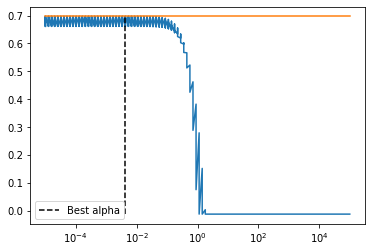

In [11]:
from pepper_skl_commons import show_alpha_path
show_alpha_path(cv_res, best_params, baseline_err, min_alpha_log, max_alpha_log, pfx='en__')

##### Recherche en grille intégrée

best alpha : 0.004139041737803772
best l1_ratio : 0.95
    train score : 0.7062513513819924
     test score : 0.6785412456122806
3-CV mean score : 0.6166554829149434
 3-CV std score : 0.059789050325773994


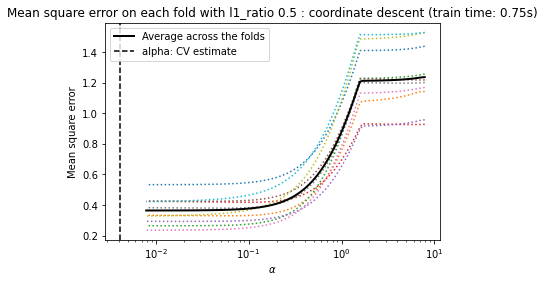

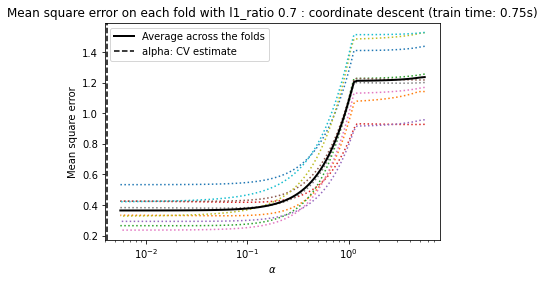

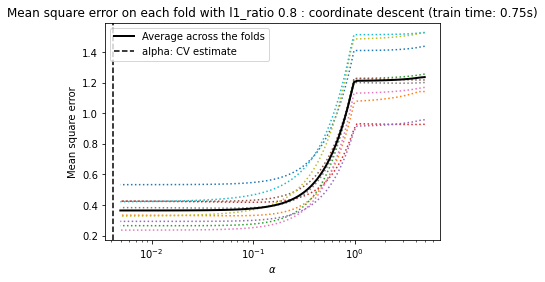

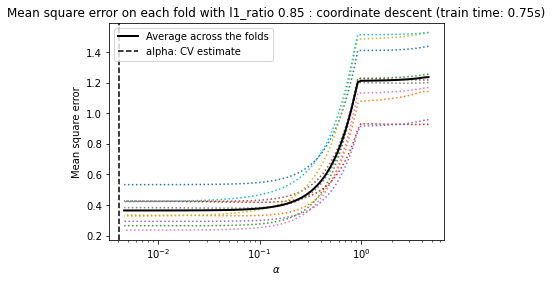

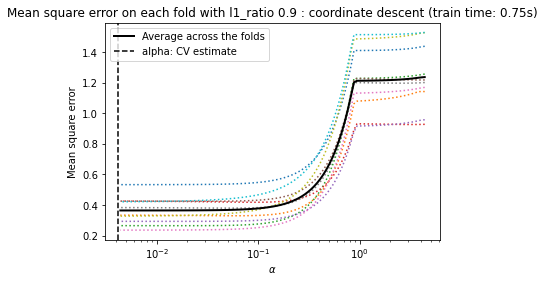

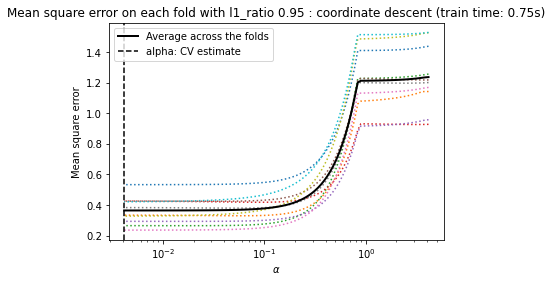

ElasticNetCV(cv=10, l1_ratio=[0.5, 0.7, 0.8, 0.85, 0.9, 0.95], random_state=42)

In [12]:
from pepper_skl_commons import builtin_best_elastic_cv_search
builtin_best_elastic_cv_search(Xy, X, y)

## Config 15 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p)$

Second test d'intégration.

$\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}$

L'ElasticCV builtin sous-performe significativement (-0.05) par rapport au LASSO.

**NB** > la normalisation des données dégrade les performances de l'estimateur.

$R^2_{15, \text{Elastic-Net, custom}}$
* $\mu = 0.7746978255403061$
* $\sigma = 0.03505299731975605$ 

$R^2_{15, \text{Elastic-Net, builtin}}$
* $\mu = 0.7341853408624098$
* $\sigma = 0.0.03997174523639183$ 

$R^2_{15, \text{LASSO}}$
* $\mu = 0.785052627954466$
* $\sigma = 0.037645015872033144$ 

$R^2_{15, \text{Ridge}}$
* $\mu = 0.7882594503864948$
* $\sigma = 0.03660944556470606$

$R^2_{15, \text{OLS}}$
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(e)\}\right)$
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [14]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

Trop de variables pour la visualisation.

#### Vérifications

In [15]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


,ptype_Low-Rise Multifamily,ptype_Mid-Rise Multifamily,ptype_Small- and Mid-Sized Office,ptype_Other,ptype_Warehouse,ptype_Large Office,ptype_Mixed Use Property,ptype_High-Rise Multifamily,ptype_Retail Store,ptype_Hotel,...,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Single Family Home,_ua_Energy/Power Station,_ua_Vocat,star_score,log(n_l),log(a),log(e)
id,,,,,,,,,,,,,,,,,,,,,
32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,-0.003151,0.000000,0.0,0.000000,0.0,62.0,2.197225,11.974620,15.488496
43,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,-1.376086,0.0,8.0,1.386294,13.111980,19.921163
100,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,96.0,1.791759,12.664465,16.439886
234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.825601,12.972641
238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,73.0,1.098612,11.420042,16.063888
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,55.5,1.098612,12.096040,16.060086
248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.979172,15.183818
264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,75.0,1.609438,11.615347,16.172386
265,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,85.0,2.079442,11.669476,16.122100


✔ No NA coefficient


#### Partition

In [16]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Sélection

In [17]:
# from pepper_skl_commons import lasso_selection
# _ = lasso_selection(X, y)

#### Lasso path using coordinate descent

In [20]:
#from pepper_skl_commons import plot_lasso_coordinate_descent_path
#plot_lasso_coordinate_descent_path(X, y)

#### Entraînement et performances

##### Recherche en grille externe

In [21]:
from pepper_skl_commons import get_lr_baseline_err
from pepper_commons import bold
baseline_err = get_lr_baseline_err(X_train, y_train)
print(bold('LR r2'), ':', baseline_err)

LR r2 : 0.03509943465204464


In [28]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_skl_commons import get_best_params
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Xy = X_train, X_test, y_train, y_test
#model = Pipeline([('sc', StandardScaler()), ('en', linear_model.ElasticNet(alpha=1))])
model = Pipeline([('en', linear_model.ElasticNet(alpha=1))])
min_alpha_log = -5
max_alpha_log = 5
n_alphas = 100

param_grid = {
    'en__alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'en__l1_ratio': [.5, .7, .8, .85, .9, .95],
    'en__positive': [True, False],
    'en__random_state': [42],
    'en__max_iter': [100_000]
}

gbp_res = (
    best_estimator, best_params, best_score, best_index, scorer, cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [29]:
from pepper_skl_commons import show_best_params
show_best_params(gbp_res, Xy, X, y)


Best
best estimator : Pipeline(steps=[('en',
                 ElasticNet(alpha=0.0016681005372000592, max_iter=100000,
                            random_state=42))])
best params : {'en__alpha': 0.0016681005372000592, 'en__l1_ratio': 0.5, 'en__max_iter': 100000, 'en__positive': False, 'en__random_state': 42}
best score : 0.801496027284095
best index : 265

Scores
    train score : 0.8350838923446186
     test score : 0.7962075908006073
3-CV mean score : 0.7746978255403061
 3-CV std score : 0.03505299731975605


In [ ]:
# TODO : feature importance
# from pepper_skl_commons import select_important_features
# features = select_important_features(best_estimator, eps=0)
# display(features)

In [30]:
from pepper_commons import print_subtitle
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_en__alpha,param_en__l1_ratio,param_en__max_iter,param_en__positive,param_en__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
265,0.008599,0.001356,0.003401,0.000490,0.001668,0.5,100000,False,42,"{'en__alpha': 0.0016681005372000592, 'en__l1_r...",0.784153,0.783678,0.814057,0.825270,0.800322,0.801496,0.016387,1
253,0.011200,0.001718,0.004601,0.001019,0.001322,0.5,100000,False,42,"{'en__alpha': 0.0013219411484660286, 'en__l1_r...",0.784387,0.781227,0.815594,0.825439,0.800507,0.801431,0.017184,2
277,0.009200,0.001326,0.004401,0.000490,0.002105,0.5,100000,False,42,"{'en__alpha': 0.00210490414451202, 'en__l1_rat...",0.783659,0.786458,0.811869,0.824849,0.798801,0.801127,0.015517,3
241,0.012398,0.002728,0.003802,0.000982,0.001048,0.5,100000,False,42,"{'en__alpha': 0.001047615752789665, 'en__l1_ra...",0.784241,0.779316,0.816366,0.825728,0.798319,0.800794,0.017920,4
267,0.007400,0.001356,0.003401,0.000489,0.001668,0.7,100000,False,42,"{'en__alpha': 0.0016681005372000592, 'en__l1_r...",0.782646,0.783478,0.811885,0.825925,0.799013,0.800589,0.016654,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,0.007200,0.000748,0.004800,0.000400,93.260335,0.8,100000,False,42,"{'en__alpha': 93.26033468832199, 'en__l1_ratio...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,663
832,0.005599,0.001199,0.003200,0.000981,93.260335,0.8,100000,True,42,"{'en__alpha': 93.26033468832199, 'en__l1_ratio...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,663
831,0.006200,0.001833,0.003400,0.000489,93.260335,0.7,100000,False,42,"{'en__alpha': 93.26033468832199, 'en__l1_ratio...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,663
845,0.007401,0.001020,0.004000,0.001095,117.681195,0.8,100000,False,42,"{'en__alpha': 117.68119524349991, 'en__l1_rati...",-0.008961,-0.015468,-0.000424,-0.038573,-0.001517,-0.012989,0.013902,663


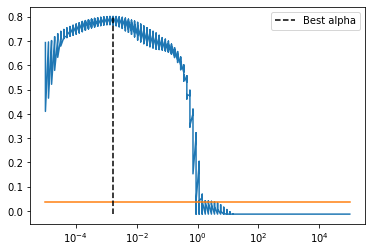

In [31]:
from pepper_skl_commons import show_alpha_path
show_alpha_path(cv_res, best_params, baseline_err, min_alpha_log, max_alpha_log, pfx='en__')

##### Recherche en grille intégrée

best alpha : 0.007370844894123375
best l1_ratio : 0.95
    train score : 0.7948337408967319
     test score : 0.7592112022128217
3-CV mean score : 0.7341853408624098
 3-CV std score : 0.03997174523639183


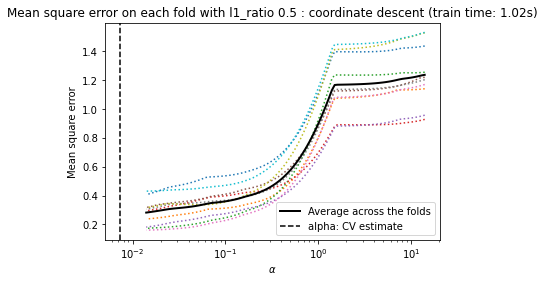

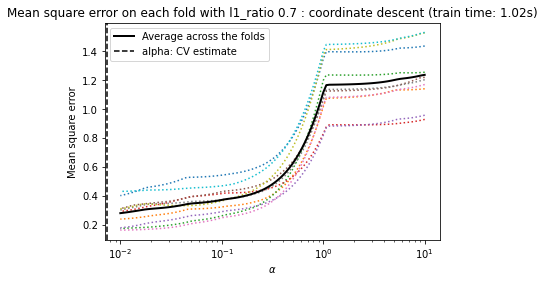

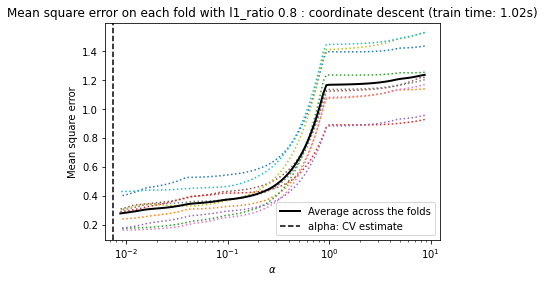

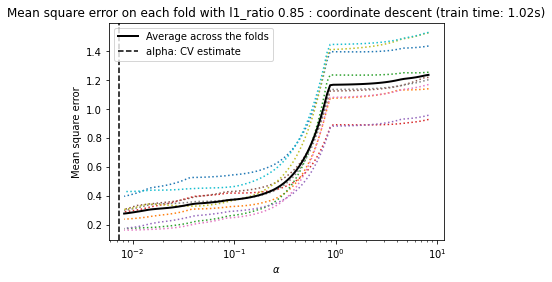

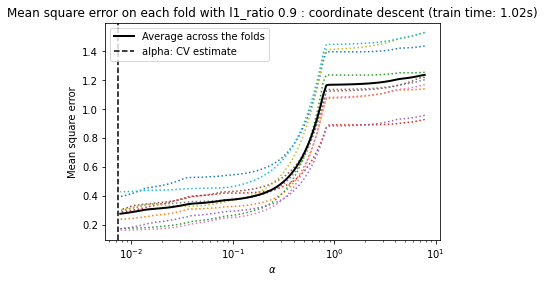

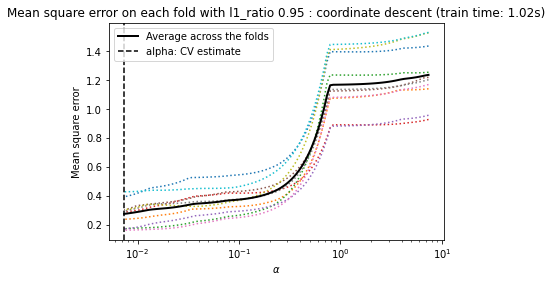

In [33]:
from pepper_skl_commons import builtin_best_elastic_cv_search
elastic = builtin_best_elastic_cv_search(Xy, X, y)

Experimental : tous les scores de régression

In [51]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import get_scorer_names
#print(get_scorer_names())
scoring = (
    'explained_variance',                    # metrics.explained_variance_score
	'max_error',                             # metrics.max_error
	'neg_mean_absolute_error',               # metrics.mean_absolute_error
	'neg_mean_squared_error',                # metrics.mean_squared_error
	'neg_root_mean_squared_error',           # metrics.mean_squared_error
	'neg_mean_squared_log_error',            # metrics.mean_squared_log_error
	'neg_median_absolute_error',             # metrics.median_absolute_error
	'r2',                                    # metrics.r2_score
	'neg_mean_poisson_deviance',             # metrics.mean_poisson_deviance
	'neg_mean_gamma_deviance',               # metrics.mean_gamma_deviance
	'neg_mean_absolute_percentage_error',    # metrics.mean_absolute_percentage_error
	#'d2_absolute_error_score',               # metrics.d2_absolute_error_score
	#'d2_pinball_score',                      # metrics.d2_pinball_score
	#'d2_tweedie_score',                      # metrics.d2_tweedie_score
)
scores = cross_validate(
    elastic, X, np.ravel(y), cv=10, scoring=scoring,
    return_train_score=True)

df_scores = pd.DataFrame.from_dict(scores, orient='index')
scores_mean = df_scores.mean(axis=1)
scores_std = df_scores.std(axis=1)
df_scores.insert(0, 'std', scores_std)
df_scores.insert(0, 'mean', scores_mean)
display(df_scores)

,mean,std,0,1,2,3,4,5,6,7,8,9
fit_time,1.485600,0.071600,1.527999,1.505000,1.482005,1.421000,1.420001,1.565999,1.618002,1.494997,1.403002,1.417999
score_time,0.005499,0.001270,0.005000,0.003000,0.005994,0.005996,0.007001,0.003998,0.005999,0.006000,0.007004,0.004999
test_explained_variance,0.694101,0.046501,0.712307,0.723814,0.609983,0.681090,0.748970,0.678111,0.671667,0.642138,0.758175,0.714750
train_explained_variance,0.786835,0.015582,0.745655,0.779435,0.798509,0.795709,0.785301,0.791227,0.794296,0.794236,0.787851,0.796133
test_max_error,-2.432981,0.428181,-2.841434,-2.579248,-2.432930,-2.133213,-3.187848,-2.164688,-1.808791,-2.311712,-2.031346,-2.838599
train_max_error,-2.919375,0.060531,-2.990220,-3.008433,-2.883177,-2.893188,-2.813377,-2.924030,-2.981641,-2.932240,-2.893429,-2.874018
test_neg_mean_absolute_error,-0.381727,0.047993,-0.478990,-0.452138,-0.380693,-0.355988,-0.354436,-0.354876,-0.364573,-0.373570,-0.319904,-0.382099
train_neg_mean_absolute_error,-0.371688,0.005255,-0.363241,-0.365381,-0.370860,-0.372789,-0.378671,-0.375803,-0.372439,-0.372498,-0.378381,-0.366815
test_neg_mean_squared_error,-0.291143,0.075818,-0.435175,-0.391193,-0.282831,-0.254340,-0.272007,-0.235636,-0.260430,-0.259121,-0.182104,-0.338593
train_neg_mean_squared_error,-0.275106,0.006214,-0.265931,-0.269822,-0.273248,-0.276911,-0.281520,-0.280499,-0.275188,-0.276339,-0.284635,-0.266972
